# Transfer Learning with TensorFlow Part 3: Scaling up (🍔👁 Food Vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

## Creating helper functions

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them.

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-01-10 05:22:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2025-01-10 05:22:22 (17.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2025-01-10 05:22:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.207, 142.251.188.207, 108.177.98.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  76.4MB/s    in 16s     

2025-01-10 05:22:46 (98.4 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
unzip_data("101_food_classes_10_percent.zip")

In [5]:
!rm "101_food_classes_10_percent.zip"

In [6]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [7]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/omelette'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/seaweed_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/paella'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheesecake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/shrimp_and_grits'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/french_toast'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/macaroni_and_cheese'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chocolate_mousse'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beignets'.
There are 0 directories and 250 

In [8]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                             label_mode="categorical",
                                                             image_size=IMG_SIZE,
                                                             shuffle=False) # Don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:

* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [9]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [10]:
# Create data augmentation layer to incorporate it right into the model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
    # layers.Rescaling(1./255) # Keep for models like ResNet50V2 but EfficientNet's having resclaing built-in
], name="data_augmentation")

In [11]:
# Setup the base model amd freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen, stay froze
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# Get a summary of model we've created
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_avg_pool_layer                │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [13]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 60s 195ms/step - accuracy: 0.1290 - loss: 4.0701 - val_accuracy: 0.4219 - val_loss: 2.7101
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 171ms/step - accuracy: 0.4158 - loss: 2.5979 - val_accuracy: 0.4288 - val_loss: 2.2768
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 169ms/step - accuracy: 0.4764 - loss: 2.1874 - val_accuracy: 0.5662 - val_loss: 1.7995
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 166ms/step - accuracy: 0.5355 - loss: 1.9447 - val_accuracy: 0.5262 - val_loss: 1.8911
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 163ms/step - accuracy: 0.5606 - loss: 1.7884 - val_accuracy: 0.5824 - val_loss: 1.6735


In [14]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 57s 72ms/step - accuracy: 0.5058 - loss: 1.9274


[1.8240731954574585, 0.5264158248901367]

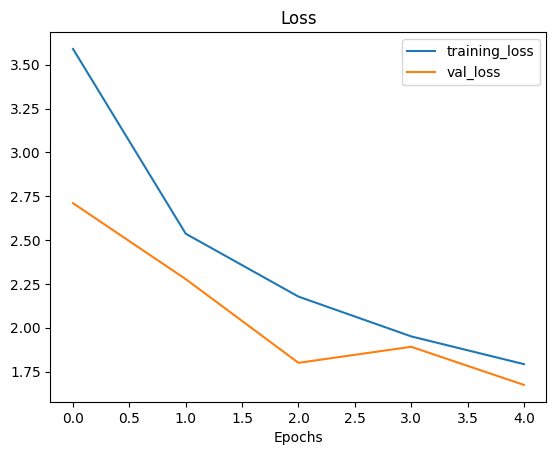

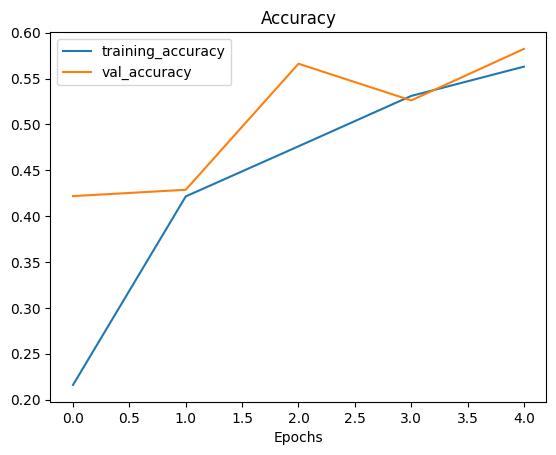

In [15]:
plot_loss_curves(history_all_classes_10_percent)

## Fine-tuning

In [16]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [17]:
# Recompile model with lower learning (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lowered by 10x
              metrics=["accuracy"])

In [18]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [19]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [20]:
# Fine-tune for 5 more epochs
FINE_TUNE_EPOCHS = 10

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=FINE_TUNE_EPOCHS,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 53s 180ms/step - accuracy: 0.5621 - loss: 1.8038 - val_accuracy: 0.4897 - val_loss: 2.0234
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 38s 162ms/step - accuracy: 0.6210 - loss: 1.5606 - val_accuracy: 0.5114 - val_loss: 1.8355
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 38s 162ms/step - accuracy: 0.6395 - loss: 1.4780 - val_accuracy: 0.6078 - val_loss: 1.5458
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 38s 161ms/step - accuracy: 0.6568 - loss: 1.3865 - val_accuracy: 0.5734 - val_loss: 1.6408
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 161ms/step - accuracy: 0.6631 - loss: 1.3589 - val_accuracy: 0.6311 - val_loss: 1.4349
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 38s 162ms/step - accuracy: 0.6754 - loss: 1.3086 - val_accuracy: 0.6059 - val_loss: 1.4509


In [21]:
# Evaluate on the whole test dataset
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 57s 72ms/step - accuracy: 0.5532 - loss: 1.7195


[1.6052364110946655, 0.5780594348907471]

In [22]:
import matplotlib.pyplot as plt

# Let's create a function to compare training histories
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow History objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history metrics with new_history metrics
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]


    # Make plot for accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label="Training Accuracy")
    plt.plot(total_val_acc, label="Val Accuracy")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning", color="r") # Plotting the line where fine tuning started
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")


    # Make plot for loss
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label="Training Loss")
    plt.plot(total_val_loss, label="Val Loss")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning", color="r") # Plotting the line where fine tuning started
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")

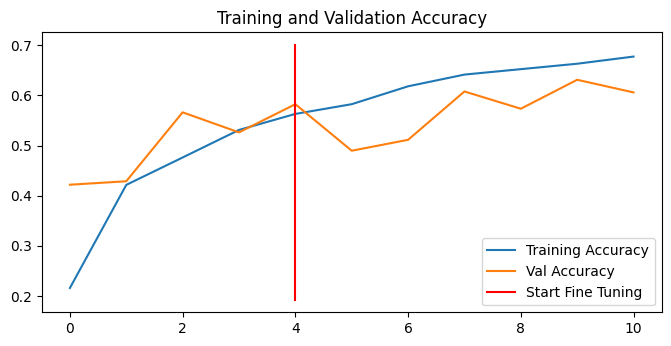

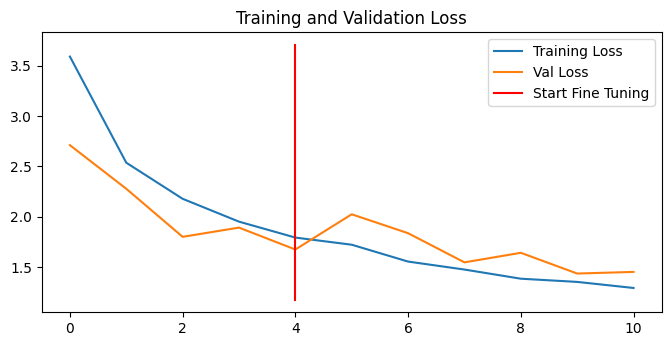

In [23]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent, new_history=history_all_classes_10_percent_fine_tune, initial_epochs=5)

## Saving and loading our model

To use our model in an external application, we'll need to save it and export it somewhere.

In [25]:
model.save("/content/models/101_food_classes_10_percent_saved_big_dog_model.keras")

In [26]:
# Load and evaluate save model
loaded_model = tf.keras.models.load_model("/content/models/101_food_classes_10_percent_saved_big_dog_model.keras")

In [27]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 62s 74ms/step - accuracy: 0.5233 - loss: 1.8447


[1.6844849586486816, 0.5559999942779541]

In [28]:
# The results from our loaded_model (above) should be very similar to the results below
all_classes_10_percent_fine_tune_results

[1.6052364110946655, 0.5780594348907471]

## Making predictions with our trained model

In [32]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) # Set verbosity to see how long is left

790/790 ━━━━━━━━━━━━━━━━━━━━ 59s 72ms/step


In [38]:
len(test_data)

790

In [39]:
# How many predictions are there?
len(preds_probs)

25250

In [40]:
# What's the shape of our predictions?
preds_probs.shape

(25250, 101)

In [41]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[4.2978904e-01, 9.2748104e-04, 8.1967004e-02, ..., 1.6043991e-04,
        6.5024262e-03, 3.2297444e-02],
       [9.2042977e-01, 5.1668785e-06, 1.5844421e-03, ..., 2.0413450e-03,
        2.1944222e-06, 1.2970752e-05],
       [2.5860438e-01, 6.4910166e-03, 4.3142098e-03, ..., 3.1263656e-03,
        4.2817590e-04, 3.2113011e-03],
       ...,
       [4.6052724e-01, 1.7714212e-05, 1.4933774e-03, ..., 4.2928040e-02,
        2.4116787e-04, 3.1543165e-04],
       [1.1937761e-01, 7.3916710e-04, 4.8505116e-02, ..., 1.6223703e-03,
        1.6612286e-04, 3.4942816e-04],
       [5.4955000e-01, 1.6974169e-05, 1.2149719e-03, ..., 1.1021985e-02,
        3.5049852e-05, 2.2789382e-03]], dtype=float32)

In [43]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([4.2978904e-01, 9.2748104e-04, 8.1967004e-02, 1.3285581e-06,
        8.0544369e-06, 1.2096690e-05, 8.6148601e-04, 1.3657220e-04,
        2.4204763e-02, 1.0039819e-03, 3.5877252e-05, 9.4311908e-05,
        2.2076243e-03, 6.5673603e-06, 1.7668968e-02, 2.5033941e-03,
        5.0663186e-04, 1.7767474e-03, 1.0888159e-03, 3.0629049e-05,
        3.4585388e-04, 3.0728689e-04, 5.1483203e-04, 9.9719362e-04,
        5.1984121e-04, 1.3155300e-03, 9.1680675e-04, 4.5540197e-05,
        3.7197109e-02, 2.8298055e-03, 1.8538698e-05, 1.9024613e-03,
        1.1444924e-03, 3.1806347e-05, 1.5975531e-02, 9.1594979e-05,
        1.1312105e-03, 3.4621377e-03, 8.5287010e-03, 7.6021563e-05,
        4.6920532e-04, 5.7999557e-04, 2.0692758e-03, 2.9438228e-05,
        7.6465833e-05, 4.3287186e-04, 1.9572817e-03, 2.9013597e-04,
        5.7782388e-05, 8.3850287e-03, 4.9216873e-03, 4.3577395e-05,
        1.4579085e-01, 1.5597583e-02, 4.1030311e-05, 1.0619211e-02,
        2.5991478e-03, 1.1101511e-03, 1.7614014e

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [44]:
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [4.2978904e-01 9.2748104e-04 8.1967004e-02 1.3285581e-06 8.0544369e-06
 1.2096690e-05 8.6148601e-04 1.3657220e-04 2.4204763e-02 1.0039819e-03
 3.5877252e-05 9.4311908e-05 2.2076243e-03 6.5673603e-06 1.7668968e-02
 2.5033941e-03 5.0663186e-04 1.7767474e-03 1.0888159e-03 3.0629049e-05
 3.4585388e-04 3.0728689e-04 5.1483203e-04 9.9719362e-04 5.1984121e-04
 1.3155300e-03 9.1680675e-04 4.5540197e-05 3.7197109e-02 2.8298055e-03
 1.8538698e-05 1.9024613e-03 1.1444924e-03 3.1806347e-05 1.5975531e-02
 9.1594979e-05 1.1312105e-03 3.4621377e-03 8.5287010e-03 7.6021563e-05
 4.6920532e-04 5.7999557e-04 2.0692758e-03 2.9438228e-05 7.6465833e-05
 4.3287186e-04 1.9572817e-03 2.9013597e-04 5.7782388e-05 8.3850287e-03
 4.9216873e-03 4.3577395e-05 1.4579085e-01 1.5597583e-02 4.1030311e-05
 1.0619211e-02 2.5991478e-03 1.1101511e-03 1.7614014e-02 1.2336163e-04
 4.8865772e-06 1.2319523e-03 4.9809041e-03 1.

In [45]:
test_data.class_names[0]

'apple_pie'

In [46]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 0,  0,  0, 38,  8, 78, 29,  0,  9,  0])

In [47]:
# How many pred classes do we have?
len(pred_classes)

25250